In [1]:
# !pip install opencv-python imgbeddings psycopg2-binary

# 1. Facial Recognition

In [15]:
# importing the cv2 library
import cv2
# loading the haar case algorithm file into alg variable
alg = "algorithms/haarcascade_frontalface_default.xml" # passing the algorithm to OpenCV
# passing the algorithm to OpenCV
haar_cascade = cv2.CascadeClassifier(alg)
# loading the image path into file_name variable - replace <INSERT YOUR IMAGE NAME HERE> with the path to your image
file_name = "pictures/celebs.png"
# reading the image
img = cv2.imread(file_name, 0)
# creating a black and white version of the image
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# detecting the faces
faces = haar_cascade.detectMultiScale(
    gray_img, scaleFactor=1.05, minNeighbors=2, minSize=(100, 100)
)

i = 0
# for each face detected
for x, y, w, h in faces:
    # crop the image to select only the face
    cropped_image = img[y : y + h, x : x + w]
    # loading the target image path into target_file_name variable  - replace  with the path to your target image
    target_file_name = 'stored-faces/' + str(i) + '.jpg'
    cv2.imwrite(
        target_file_name,
        cropped_image,
    )
    i = i + 1;


# 2. Create embeddings

Calculate embeddings from the faces and pushing to PostgreSQL

In [12]:
# importing the required libraries
import numpy as np
from imgbeddings import imgbeddings
from PIL import Image
import psycopg2
import os

# connecting to the database - replace the SERVICE URI with the service URI
conn = psycopg2.connect("INSERT-SERVICE URI")

for filename in os.listdir("stored-faces"):
    # opening the image
    img = Image.open("stored-faces/" + filename)
    # loading the `imgbeddings`
    ibed = imgbeddings()
    # calculating the embeddings
    embedding = ibed.to_embeddings(img)
    cur = conn.cursor()
    cur.execute("INSERT INTO pictures values (%s,%s)", (filename, embedding[0].tolist()))
    print(filename)
conn.commit()

# 3. Calculate embeddings on a new picture

In [13]:
# loading the face image path into file_name variable
file_name = "pictures/brad.png"  # replace with the path to your image
# opening the image
img = Image.open(file_name)
# loading the `imgbeddings`
ibed = imgbeddings()
# calculating the embeddings
embedding = ibed.to_embeddings(img)

# 4. Find similar images by querying Posgresql database using pgvector

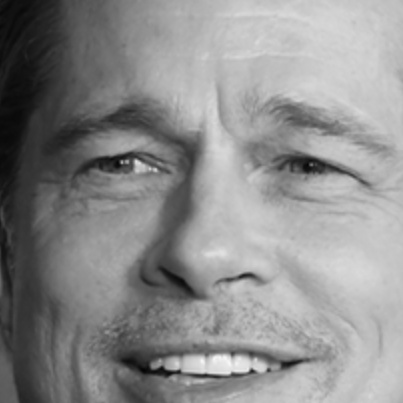

In [14]:
from IPython.display import Image, display

cur = conn.cursor()
string_representation = "["+ ",".join(str(x) for x in embedding[0].tolist()) +"]"
cur.execute("SELECT * FROM pictures ORDER BY embedding <-> %s LIMIT 1;", (string_representation,))
rows = cur.fetchall()
for row in rows:
    display(Image(filename="stored-faces/"+row[0]))
cur.close()